In [1]:
import copy
import time
import warnings
import torch

import numpy as np
import pandas as pd
from src.envs.custom.highway import CustomHighwayEnv
from src.util import load_config

from highway_env import utils
from highway_env.vehicle.controller import ControlledVehicle
from highway_env.envs.common.graphics import EnvViewer


from aix360.algorithms.rbm import FeatureBinarizer
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG, GLRMExplainer, LogisticRuleRegression
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from src.envs.custom.gridworld import Gridworld
from src import util
from stable_baselines3 import DQN
from typing import Any, Dict, List, Optional, Tuple, Type, Union
import gym
from stable_baselines3.common.utils import obs_as_tensor
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',10)
import matplotlib.pyplot as plt
import seaborn as sns
from highway_rules import run_rules_models, train_rules_model, create_training_dataframes,construct_rules
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/james/miniconda3/envs/aix360/lib/python3.6/site-packages/gym/core.py:27: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
ACTIONS = {'turn': [0, 2],
           'forward': [1, 3, 4],
           'left': 0,
           'right': 2,
           'idle': 1,
           'faster': 3,
           'slower': 4,
           0:'left',
           2:'right',
           1:'idle',
           3:'faster',
           4:'slower'}

FEATURES = {'descriptive': ['speed', 'dist_to_car_in_front', 'car_infront_speed', 'car_infront_dir', 'x_left_car', 'y_left_car',
                            'dir_left_car', 'x_right_car', 'y_right_car', 'dir_right_car'],  # ,'prox_to_right_lane']
            'state': ['ego_y', 'ego_x', 'ego_velocity_y', 'ego_velocity_x',
                      'vehicle_1_y', 'vehicle_1_x', 'vehicle_1_velocity_y', 'vehicle_1_velocity_x',
                      'vehicle_2_y', 'vehicle_2_x', 'vehicle_2_velocity_y', 'vehicle_2_velocity_x']}
                      #'vehicle_3_y', 'vehicle_3_x', 'vehicle_3_velocity_y', 'vehicle_3_velocity_x',
                      #'vehicle_4_y', 'vehicle_4_x', 'vehicle_4_velocity_y', 'vehicle_4_velocity_x']}
CATEG_COL = {'descriptive': ['speed', 'dist_to_car_in_front', 'car_infront_speed', 'car_infront_dir', 'x_left_car', 'y_left_car',
                            'dir_left_car', 'x_right_car', 'y_right_car', 'dir_right_car'],
             'state': None}
             
def setup_env():
    env_config = load_config('./config/env/highway.json')
    #env = gym.make('highway-fast-v0')
    env = CustomHighwayEnv(shaping=False, time_window=env_config['time_window'])
    env.config['right_lane_reward'] = env_config['right_lane_reward']
    env.config['lanes_count'] = env_config['lanes_count']
    env.config['offscreen_rendering'] = False
    env.config['simulation_frequency'] = 5
    env.set_true_reward(env_config['true_reward_func'])
    return env


env =setup_env()

In [4]:
def construct_rules(explainer_model,dtype = 'object'):
    """
    Parses the rules generated by the explanation model and returns a form that is suitable for
    dataframe "querying"
    """
    constructed_rules = []
    for rule in explainer_model['rules']:
        split_rule = [part.lower() if part ==
                      'AND' else part for part in rule.split(' ')]
        constructed_rule = []
        if len(split_rule) == 0:
            break
        for i in range(len(split_rule)):
            if i != 0:
                if split_rule[i-1] == '==':
                    # enforce objects that get converted to floats by rules model remain as objects
                    if dtype == 'object':
                        value  = str(int(float(split_rule[i])))
                    else:
                        value = split_rule[i]
                    constructed_rule.append(f"'{value}'")
                    continue
            constructed_rule.append(split_rule[i])
        constructed_rules.append(" ".join(constructed_rule))
    return constructed_rules

def create_summary_df(df, constructed_rules, features, target_feature, target):
    """
    Creates summary dataframe for agreements and disagreements of each rule
    """
    summary_df = pd.DataFrame(
        columns=['rule', 'total_support', 'agree', 'disagree', 'unique_states'])
    data_cols = features + [target_feature]
    for rule in constructed_rules:
        row = {}
        d = df[data_cols].query(rule)
        row['rule'] = rule
        row['total_support'] = d[target_feature].count()
        row['agree'] = len(d[d[target_feature] == target])
        row['agree_percentage'] = row['agree']/row['total_support']
        row['disagree'] = len(d[d[target_feature] != target])
        row['disagree_percentage'] = row['disagree']/row['total_support']
        row['unique_states'] = len(
            d.drop(target_feature, axis=1).value_counts())
        summary_df = summary_df.append(row, ignore_index=True)
    return summary_df

def summarise_rules(data, features, target, explanations):
    target_value = 1  # always positive value for target
    constructed_rules = construct_rules(explainer_model=explanations)
    if not constructed_rules or len(constructed_rules[0]) == 0:
        print('no rules')
        return
    summary_df = create_summary_df(df=data, constructed_rules=constructed_rules,
                                   features=features, target_feature=target, target=target_value)
    print(summary_df)
    return summary_df



In [6]:
baseline = pd.read_csv('data/dataframes/baseline_model.csv').drop('Unnamed: 0',axis=1)
expert = pd.read_csv('data/dataframes/expert_model.csv').drop('Unnamed: 0',axis=1)
baseline['agent'] = 'baseline'
expert['agent'] = 'expert'
"""
baseline['baseline_action'] = baseline['baseline_action'].transform(lambda x: ACTIONS[x])
baseline['alternate_action'] = baseline['alternate_action'].transform(lambda x: ACTIONS[x])
expert['baseline_action'] = expert['baseline_action'].transform(lambda x: ACTIONS[x])
expert['alternate_action'] = expert['alternate_action'].transform(lambda x: ACTIONS[x])
"""
combined_df = baseline.append(expert).reset_index().drop('level_0',axis=1)
combined_df['car_infront_dir'] = combined_df[['car_infront_speed','car_infront_dir']].apply(lambda x: 99 if (x.car_infront_speed == 99 and x.car_infront_dir == 0) else x.car_infront_dir,axis=1)
combined_df['dir_left_car'] = combined_df[['x_left_car','dir_left_car']].apply(lambda x: 99 if (x.x_left_car == 99 and x.dir_left_car ==0) else x.dir_left_car,axis=1)
combined_df['dir_right_car'] = combined_df[['x_right_car','dir_right_car']].apply(lambda x: 99 if (x.x_right_car == 99 and x.dir_right_car == 0) else x.dir_right_car,axis=1)
combined_df.replace(99,np.nan,inplace=True)

combined_df['speed_labels'] = pd.cut(combined_df['speed'],bins=4,include_lowest=True)
combined_df['speed'] = pd.cut(combined_df['speed'],bins=4,labels=False,include_lowest=True)
combined_df['dist_to_car_in_front_labels'] = pd.cut(combined_df['dist_to_car_in_front'],bins=5,include_lowest=True)
combined_df['dist_to_car_in_front'] = pd.cut(combined_df['dist_to_car_in_front'],bins=5,labels=False,include_lowest=True)
combined_df['car_infront_dir_labels'] = pd.cut(combined_df['car_infront_dir'],bins=4,include_lowest=True)
combined_df['car_infront_dir'] = pd.cut(combined_df['car_infront_dir'],bins=4,labels=False,include_lowest=True)
combined_df['car_infront_speed_labels'] = pd.cut(combined_df['car_infront_speed'],bins=4,include_lowest=True)
combined_df['car_infront_speed'] = pd.cut(combined_df['car_infront_speed'],bins=4,labels=False,include_lowest=True)
combined_df['x_left_car_labels'] = pd.cut(combined_df['x_left_car'],bins=6,include_lowest=True)
combined_df['x_left_car'] = pd.cut(combined_df['x_left_car'],bins=6,labels=False,include_lowest=True)
combined_df['y_left_car_labels'] = pd.cut(combined_df['y_left_car'],bins=6,include_lowest=True)
combined_df['y_left_car'] = pd.cut(combined_df['y_left_car'],bins=6,labels=False,include_lowest=True)
combined_df['dir_left_car_labels'] = pd.cut(combined_df['dir_left_car'],bins=4,include_lowest=True)
combined_df['dir_left_car'] = pd.cut(combined_df['dir_left_car'],bins=4,labels=False,include_lowest=True)
combined_df['x_right_car_labels'] = pd.cut(combined_df['x_right_car'],bins=6,include_lowest=True)
combined_df['x_right_car'] = pd.cut(combined_df['x_right_car'],bins=6,labels=False,include_lowest=True)
combined_df['y_right_car_labels'] = pd.cut(combined_df['y_right_car'],bins=6,include_lowest=True)
combined_df['y_right_car'] = pd.cut(combined_df['y_right_car'],bins=6,labels=False,include_lowest=True)
combined_df['dir_right_car_labels'] = pd.cut(combined_df['dir_right_car'],bins=4,include_lowest=True)
combined_df['dir_right_car'] = pd.cut(combined_df['dir_right_car'],bins=4,labels=False,include_lowest=True)
combined_df[FEATURES['descriptive']] = combined_df[FEATURES['descriptive']].fillna(99)
for col in FEATURES['descriptive']:
    combined_df[col] = combined_df[col].astype('object')
dones = np.where(combined_df.done == True)[0]
start = 0 
combined_df['episode'] = 0
episode = 1
for i in dones:
    combined_df['episode'].iloc[start:i+1] = episode
    start = i + 1
    episode += 1
summary_stats = combined_df.groupby(['agent','episode'])['reward'].sum().reset_index()
summary_stats['ep_len'] = combined_df.groupby(['agent','episode'])['reward'].count().reset_index()['reward']
summary_stats

,agent,episode,reward,ep_len
0,baseline,1,21.835916,23
1,baseline,2,29.973797,30
2,baseline,3,29.852251,30
3,baseline,4,29.283008,30
4,baseline,5,29.975805,30
...,...,...,...,...
1995,expert,1996,29.976311,30
1996,expert,1997,29.976322,30
1997,expert,1998,29.975805,30
1998,expert,1999,29.263549,30


In [7]:
# lag features 
lagged_features = []
lag_1_df = pd.DataFrame()
for i in range(1,3):
    for feature in FEATURES['descriptive']:
        lagged_feature = f'{feature}_lagged_{i}'
        combined_df[lagged_feature] = combined_df[feature].shift(i)
        lagged_features.append(lagged_feature)
FEATURES['descriptive'] = FEATURES['descriptive'] + lagged_features
combined_df['done_t_1'] = combined_df['done'].shift(1)
combined_df['done_t_2'] = combined_df['done'].shift(2)
combined_df = combined_df.drop(combined_df[((combined_df['done_t_1'] == True) & (combined_df['done'] == False)) | ((combined_df['done_t_2'] == True) & (combined_df['done'] == False))].index)
combined_df.dropna(inplace=True)

In [41]:
categories = [col_name for col_name in combined_df.columns if '_label' in col_name]
for cat in categories:
    print(cat, combined_df[cat].cat.categories.values)

speed_labels <IntervalArray>
[(19.951999999999998, 22.472], (22.472, 24.981], (24.981, 27.491], (27.491, 30.0]]
Length: 4, closed: right, dtype: interval[float64]
dist_to_car_in_front_labels <IntervalArray>
[(-0.0518, 0.1], (0.1, 0.25], (0.25, 0.4], (0.4, 0.55], (0.55, 0.7]]
Length: 5, closed: right, dtype: interval[float64]
car_infront_dir_labels <IntervalArray>
[(-0.101, -0.05], (-0.05, 0.0], (0.0, 0.05], (0.05, 0.1]]
Length: 4, closed: right, dtype: interval[float64]
car_infront_speed_labels <IntervalArray>
[(-0.301, -0.215], (-0.215, -0.13], (-0.13, -0.045], (-0.045, 0.04]]
Length: 4, closed: right, dtype: interval[float64]
x_left_car_labels <IntervalArray>
[(-0.0517, 0.0583], (0.0583, 0.167], (0.167, 0.275], (0.275, 0.383], (0.383, 0.492], (0.492, 0.6]]
Length: 6, closed: right, dtype: interval[float64]
y_left_car_labels <IntervalArray>
[(0.997, 1.333], (1.333, 1.667], (1.667, 2.0], (2.0, 2.333], (2.333, 2.667], (2.667, 3.0]]
Length: 6, closed: right, dtype: interval[float64]
dir_

In [15]:
early_ends = summary_stats[summary_stats['ep_len']<30]
early_ends_df = combined_df[combined_df['episode'].isin(summary_stats['episode'])]
early_ends.groupby('agent').reward.mean()

agent
baseline    13.740382
expert      14.551161
Name: reward, dtype: float64

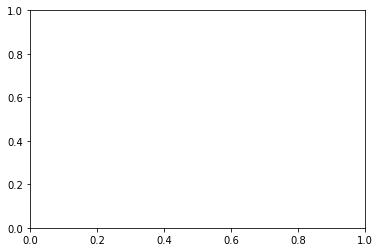

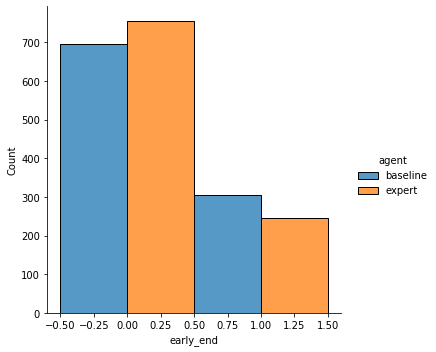

In [7]:
summary_stats['early_end'] = summary_stats['ep_len'].apply(lambda x: 1 if x < 30 else 0)
fig,ax = plt.subplots()
sns.displot(data=summary_stats,x = 'early_end',hue='agent',discrete=True,multiple='dodge')

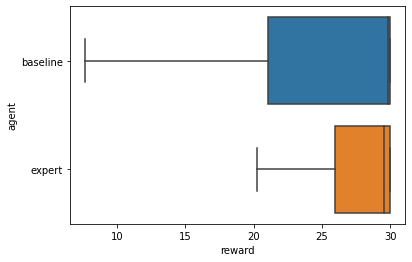

In [8]:
fig,ax = plt.subplots()
sns.boxplot(data =summary_stats,x='reward', y='agent',showfliers=False)
plt.show()

In [9]:
over_20s = summary_stats[summary_stats['reward'] >=20]
good_df =  combined_df[combined_df['episode'].isin(over_20s['episode'])]

In [10]:
baseline_turn_right = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='turn_right',features=FEATURES,categ_col=CATEG_COL)
baseline_turn_right[2].to_csv('data/summary/lagged/baseline_turn_right.csv')
baseline_turn_left = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='turn_left',features=FEATURES,categ_col=CATEG_COL)
baseline_turn_left[2].to_csv('data/summary/lagged/baseline_turn_left.csv')
baseline_forward_faster = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_faster',features=FEATURES,categ_col=CATEG_COL)
baseline_forward_faster[2].to_csv('data/summary/lagged/baseline_forward_faster.csv')
baseline_forward_slower = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_slower',features=FEATURES,categ_col=CATEG_COL)
baseline_forward_slower[2].to_csv('data/summary/lagged/baseline_forward_slower.csv')
baseline_forward_idle = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_idle',features=FEATURES,categ_col=CATEG_COL)
baseline_forward_idle[2].to_csv('data/summary/lagged/baseline_forward_idle.csv')

turn
Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2086
Iteration: 2, Objective: 0.2025
Iteration: 3, Objective: 0.1827
Iteration: 4, Objective: 0.1730
Iteration: 5, Objective: 0.1692
Iteration: 6, Objective: 0.1692
Iteration: 7, Objective: 0.1684
Iteration: 8, Objective: 0.1676
Iteration: 9, Objective: 0.1673
Iteration: 10, Objective: 0.1637
Iteration: 11, Objective: 0.1637
Iteration: 12, Objective: 0.1637
Accuracy 0.8265971316818774
0.6295264623955431
{'isCNF': False, 'rules': ['dist_to_car_in_front_lagged_2 == 1.0 AND x_left_car_lagged_2 == 99.0', 'dir_left_car == 1.0 AND dist_to_car_in_front_lagged_1 == 0.0', 'x_left_car_lagged_1 == 1.0 AND speed_lagged_2 == 3 AND x_left_car_lagged_2 == 1.0', 'x_left_car == 1.0 AND dist_to_car_in_front_lagged_1 == 1.0 AND y_right_car_lagged_2 == 2.0']}
Agent chooses right if ANY of the following rules are satisfied, otherwise Agent does NOT choose right:
  - dist_to_car_in_fro

In [34]:
rules = baseline_turn_right[2]
for i in range(len(rules)):
    rule = rules['rule'][i]
    for j in rule.split('and'):
        var = j.split(' ')[0]
        eq = j.split(' ')[1]
        val = j.split(' ')[-1]
        if '_lagged' in var:
            var_clean = var.split('_lagged')[0]
        else:
            var_clean = var
        if var_clean+'_labels' in good_df.columns:
            print(val)
            category = good_df[var_clean+'_labels'].cat.categories[int(float(val))]
            rule = var + eq + category
            print(rule)
    

ValueError: could not convert string to float: 

In [14]:
baseline_turn = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='turn_right',features=FEATURES,categ_col=CATEG_COL,method='dual_type')
baseline_turn[2].to_csv('data/summary/baseline_turn.csv')
baseline_forward = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_faster',features=FEATURES,categ_col=CATEG_COL,method='dual_type')
baseline_forward[2].to_csv('data/summary/baseline_forward.csv')

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.3787
Iteration: 2, Objective: 0.3374
Iteration: 3, Objective: 0.3260
Iteration: 4, Objective: 0.3260
Iteration: 5, Objective: 0.3260
Iteration: 6, Objective: 0.3260
Iteration: 7, Objective: 0.3255
Accuracy 0.705562095350206
0.5373410404624277
{'isCNF': False, 'rules': ['speed == 3 AND dist_to_car_in_front == 0.0', 'speed == 3 AND dist_to_car_in_front == 1.0 AND x_left_car == 99.0']}
Agent chooses right if ANY of the following rules are satisfied, otherwise Agent does NOT choose right:
  - speed == 3 AND dist_to_car_in_front == 0.0
  - speed == 3 AND dist_to_car_in_front == 1.0 AND x_left_car == 99.0
                                                rule total_support agree  \
0           speed == 3 and dist_to_car_in_front == 0          1935  1771   
1  speed == 3 and dist_to_car_in_front == 1 and x...          4507  2185   

  disagree unique_states  agree_percentage  d

In [15]:
baseline_turn_right = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='turn_right',features=FEATURES,categ_col=CATEG_COL,method='one_vs_rest')
baseline_turn_right[2].to_csv('data/summary/baseline_turn_right_ova.csv')
baseline_turn_left = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='turn_left',features=FEATURES,categ_col=CATEG_COL,method='one_vs_rest')
baseline_turn_left[2].to_csv('data/summary/baseline_turn_left_ova.csv')
baseline_forward_faster = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_faster',features=FEATURES,categ_col=CATEG_COL,method='one_vs_rest')
baseline_forward_faster[2].to_csv('data/summary/baseline_forward_faster_ova.csv')
baseline_forward_slower = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_slower',features=FEATURES,categ_col=CATEG_COL,method='one_vs_rest')
baseline_forward_slower[2].to_csv('data/summary/baseline_forward_slower_ova.csv')
baseline_forward_idle = train_rules_model(good_df[good_df['agent']=='baseline'],feature_type='descriptive',target='baseline_action',action='forward_idle',features=FEATURES,categ_col=CATEG_COL,method='one_vs_rest')
baseline_forward_idle[2].to_csv('data/summary/baseline_forward_idle_ova.csv')

Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2851
Iteration: 2, Objective: 0.2447
Iteration: 3, Objective: 0.2447
Iteration: 4, Objective: 0.2447
Iteration: 5, Objective: 0.2447
Iteration: 6, Objective: 0.2432
Accuracy 0.7477928193054738
0.40320334261838436
{'isCNF': False, 'rules': ['dist_to_car_in_front == 0.0', 'speed == 3 AND dist_to_car_in_front == 1.0 AND dir_left_car == 99.0']}
Agent chooses right if ANY of the following rules are satisfied, otherwise Agent does NOT choose right:
  - dist_to_car_in_front == 0.0
  - speed == 3 AND dist_to_car_in_front == 1.0 AND dir_left_car == 99.0
                                                rule total_support agree  \
0                          dist_to_car_in_front == 0          2735  1257   
1  speed == 3 and dist_to_car_in_front == 1 and d...          4507   665   

  disagree unique_states  agree_percentage  disagree_percentage  
0     1478           402          0

In [16]:
expert_turn_left = train_rules_model(good_df[good_df['agent']=='expert'],feature_type='descriptive',target='baseline_action',action='turn_left')
expert_turn_left[2].to_csv('data/summary/expert_turn_left.csv')
expert_turn_right = train_rules_model(good_df[good_df['agent']=='expert'],feature_type='descriptive',target='baseline_action',action='turn_right')
expert_turn_right[2].to_csv('data/summary/expert_turn_right.csv')
expert_forward_faster = train_rules_model(good_df[good_df['agent']=='expert'],feature_type='descriptive',target='baseline_action',action='forward_faster')
expert_forward_faster[2].to_csv('data/summary/expert_forward_faster.csv')
expert_forward_slower = train_rules_model(good_df[good_df['agent']=='expert'],feature_type='descriptive',target='baseline_action',action='forward_slower')
expert_forward_slower[2].to_csv('data/summary/expert_forward_slower.csv')
expert_forward_idle = train_rules_model(good_df[good_df['agent']=='expert'],feature_type='descriptive',target='baseline_action',action='forward_idle')
expert_forward_idle[2].to_csv('data/summary/expert_forward_idle.csv')

turn
Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.3742
Iteration: 2, Objective: 0.3526
Iteration: 3, Objective: 0.3298
Iteration: 4, Objective: 0.3157
Iteration: 5, Objective: 0.3102
Iteration: 6, Objective: 0.3060
Iteration: 7, Objective: 0.3060
Iteration: 8, Objective: 0.3060
Accuracy 0.6772853185595568
0.4989247311827957
{'isCNF': False, 'rules': ['x_left_car == 5.0', 'dist_to_car_in_front == 99.0 AND x_right_car == 0.0', 'dist_to_car_in_front == 2.0 AND x_right_car == 0.0', 'dist_to_car_in_front == 1.0 AND x_left_car == 3.0', 'dist_to_car_in_front == 0.0 AND car_infront_speed == 2.0 AND y_right_car == 99.0', 'speed == 3 AND x_right_car == 1.0 AND y_right_car == 0.0']}
Agent chooses left if ANY of the following rules are satisfied, otherwise Agent does NOT choose left:
  - x_left_car == 5.0
  - dist_to_car_in_front == 99.0 AND x_right_car == 0.0
  - dist_to_car_in_front == 2.0 AND x_right_car == 0.0
  - dist_t

In [32]:
turn_disagree = train_rules_model(good_df,feature_type='descriptive',target='disagreement_turn',action='turn',method='single_type')
turn_disagree[2].to_csv('data/summary/turn_disagree.csv')
turn_agree = train_rules_model(good_df,feature_type='descriptive',target='agreement_turn',action='turn',method='single_type')
turn_agree[2].to_csv('data/summary/turn_agree.csv')
forward_disagree = train_rules_model(good_df,feature_type='descriptive',target='disagreement_forward',action='forward',method='single_type')
forward_disagree[2].to_csv('data/summary/forward_disagree.csv')
forward_agree = train_rules_model(good_df,feature_type='descriptive',target='agreement_forward',action='forward',method='single_type')
forward_agree[2].to_csv('data/summary/forward_agree.csv')

turn
Learning DNF rule with complexity parameters lambda0=0.001, lambda1=0.001
Initial LP solved
Iteration: 1, Objective: 0.2629
Iteration: 2, Objective: 0.2611
Iteration: 3, Objective: 0.2509
Iteration: 4, Objective: 0.2509
Iteration: 5, Objective: 0.2509
Iteration: 6, Objective: 0.2509
Accuracy 0.7193850964043773
0.6743271847596009
{'isCNF': False, 'rules': ['dist_to_car_in_front == 2.0', 'dist_to_car_in_front == 3.0', 'dist_to_car_in_front == 99.0', 'car_infront_dir == 99.0 AND dir_left_car == 1.0', 'speed == 2 AND dist_to_car_in_front == 1.0', 'dist_to_car_in_front == 1.0 AND x_right_car == 0.0 AND y_right_car == 0.0']}
Agent disagree if ANY of the following rules are satisfied, otherwise Agent agree:
  - dist_to_car_in_front == 2.0
  - dist_to_car_in_front == 3.0
  - dist_to_car_in_front == 99.0
  - car_infront_dir == 99.0 AND dir_left_car == 1.0
  - speed == 2 AND dist_to_car_in_front == 1.0
  - dist_to_car_in_front == 1.0 AND x_right_car == 0.0 AND y_right_car == 0.0
           

AttributeError: 'NoneType' object has no attribute 'to_csv'

In [19]:
df,_, x_train_fb,x_test_fb, y_train_code, y_test_code = create_training_dataframes(good_df,feature_type='descriptive',target='disagreement_turn',action=None,
    stability_filter=False,features=FEATURES,categ_col=CATEG_COL,method='dual_type')

In [23]:
df[df['train_test'] == 'train']

,ego_y,ego_x,ego_velocity_y,ego_velocity_x,vehicle_1_y,...,disagreement_turn,disagreement_forward,agreement_turn,agreement_forward,train_test
0,0.000000,0.673002,0.000000e+00,0.312500,0.500000,...,0,0,0,1,train
1,0.000000,0.809977,0.000000e+00,0.366770,0.378147,...,0,0,0,1,train
2,0.000000,0.958262,0.000000e+00,0.373916,0.257757,...,0,1,0,0,train
4,0.000000,1.000000,0.000000e+00,0.374981,0.500485,...,0,0,0,1,train
5,0.000000,1.000000,0.000000e+00,0.374998,0.750000,...,0,0,0,1,train
...,...,...,...,...,...,...,...,...,...,...,...
51896,0.500217,1.000000,-1.984883e-04,0.375000,-0.000217,...,0,0,1,0,train
51897,0.268547,1.000000,-1.287926e-02,0.374779,0.231453,...,0,1,0,0,train
51898,0.250217,1.000000,-1.984242e-04,0.375000,0.499783,...,0,0,0,1,train
51899,0.249998,1.000000,5.098966e-07,0.375000,0.000002,...,0,1,0,0,train


In [30]:
df[df['train_test'] == 'train']['disagreement_turn'].value_counts()

0    28456
1     4568
Name: disagreement_turn, dtype: int64

In [26]:
y_train_code.sum()

28456

In [12]:
# transform actions
good_df['baseline_action'] = good_df['baseline_action'].transform(lambda x: ACTIONS[x])
good_df['alternate_action'] = good_df['alternate_action'].transform(lambda x: ACTIONS[x])

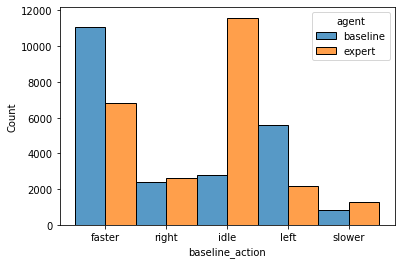

In [13]:
fig, ax = plt.subplots()
sns.histplot(good_df, x='baseline_action', ax=ax, hue='agent',discrete=True,multiple='dodge')
ax.set_xticks(range(0,5))
plt.show()

ValueError: Could not interpret input 'agent'

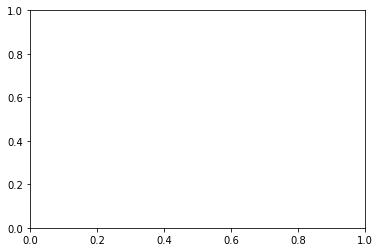

In [14]:
fig, ax = plt.subplots()
sns.boxplot(combined_df, x='reward', ax=ax, y='agent')
ax.set_xticks(range(0,5))
plt.show()

# Clustering of States - > Actions


In [27]:
kmeans = KMeans(n_clusters=2)
x_train,y_train = data_dict['x_train'],data_dict['y_train']
clusters = kmeans.fit_predict(x_train)

In [35]:
x_train = combined_df[combined_df['baseline_action'].isin(ACTIONS['turn'])][FEATURES['state']]

In [42]:
tsne = TSNE(n_components=2,verbose=1,perplexity=80,n_iter=5000,learning_rate=200)
x_tsne_results = tsne.fit_transform(x_train)

[t-SNE] Computing 241 nearest neighbors...
[t-SNE] Indexed 14246 samples in 0.021s...
[t-SNE] Computed neighbors for 14246 samples in 1.258s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14246
[t-SNE] Computed conditional probabilities for sample 2000 / 14246
[t-SNE] Computed conditional probabilities for sample 3000 / 14246
[t-SNE] Computed conditional probabilities for sample 4000 / 14246
[t-SNE] Computed conditional probabilities for sample 5000 / 14246
[t-SNE] Computed conditional probabilities for sample 6000 / 14246
[t-SNE] Computed conditional probabilities for sample 7000 / 14246
[t-SNE] Computed conditional probabilities for sample 8000 / 14246
[t-SNE] Computed conditional probabilities for sample 9000 / 14246
[t-SNE] Computed conditional probabilities for sample 10000 / 14246
[t-SNE] Computed conditional probabilities for sample 11000 / 14246
[t-SNE] Computed conditional probabilities for sample 12000 / 14246
[t-SNE] Computed conditional probabilities for sa

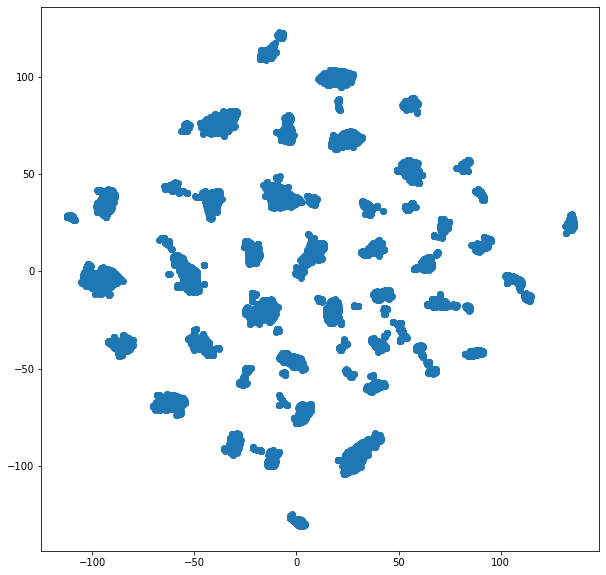

In [46]:
plt.figure(figsize=(10,10))
plt.scatter(x_tsne_results[:,0],x_tsne_results[:,1])
plt.show()

In [45]:
x_tsne_results[0]

array([-95.15474  ,  -2.7532995], dtype=float32)

In [26]:
s = 'split'
s.split('_')

['split']

In [14]:
d ={'kar':4,'key':3}
np.array(list(d.items()))

array([['kar', '4'],
       ['key', '3']], dtype='<U3')

In [ ]:
,